In [1]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [2]:
# Reading the saved data pickle file
df_stocks = pd.read_pickle('Data/data.pkl')

In [3]:
df_stocks.head()

,close,adj close,articles
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...


In [4]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [5]:
# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

In [6]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

In [7]:
df_stocks.head()

,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...


In [8]:
df = df_stocks[['prices']].copy()
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


In [9]:
# Adding new columns to the data frame
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [10]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,


In [95]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles'])#.encode('ascii','ignore')
        ss = sid.polarity_scores(sentence)
        df.set_value(date, 'compound', ss['compound'])
        df.set_value(date, 'neg', ss['neg'])
        df.set_value(date, 'neu', ss['neu'])
        df.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print (df_stocks.loc[date, 'articles'])
        print (date)

In [96]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9735,0.153,0.748,0.099
2007-01-02,12472,-0.9702,0.122,0.786,0.092
2007-01-03,12474,-0.9994,0.203,0.736,0.06
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082


In [97]:
train_start_date = '2007-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2016-12-31'
train = df.ix[train_start_date : train_end_date]
test = df.ix[test_start_date:test_end_date]

In [106]:
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [107]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [108]:
y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])

## Random Forest

In [112]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [113]:
rf.feature_importances_

array([ 0.54641205,  0.45358795])

In [128]:
prediction, bias, contributions = ti.predict(rf, numpy_df_test)

In [129]:
prediction[:10]

array([ 13558.7       ,  13942.925     ,  12953.85      ,  13003.9       ,
        14081.        ,  16317.99166667,  12401.1       ,  12080.9       ,
        12296.        ,  12781.2       ])

In [130]:
contributions[:10]

array([[ 1459.25017049,  -470.05294256],
       [  242.76829948,  1130.65392845],
       [  358.94275065,    25.40447728],
       [ -927.4049431 ,  1361.80217102],
       [  -12.96635479,  1524.46358271],
       [ 2234.05919775,  1514.42969684],
       [  484.44068777,  -652.84345984],
       [ -873.94526114,   385.34248906],
       [  -81.3227129 ,  -192.18005917],
       [ -429.75856249,   641.45579041]])

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
idx = pd.date_range(test_start_date, test_end_date)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])

In [140]:
predictions_df.tail()

,prices
2016-12-27,13324.975833
2016-12-28,12527.800000
2016-12-29,13598.630000
2016-12-30,12189.540000
2016-12-31,14120.000000


In [139]:
df.tail()

,prices,compound,neg,neu,pos
2016-12-27,19945,-0.9898,0.178,0.719,0.103
2016-12-28,19833,0.2869,0.128,0.763,0.108
2016-12-29,19819,-0.9789,0.138,0.764,0.097
2016-12-30,19762,-0.9959,0.173,0.733,0.094
2016-12-31,19762,-0.2869,0.173,0.665,0.161


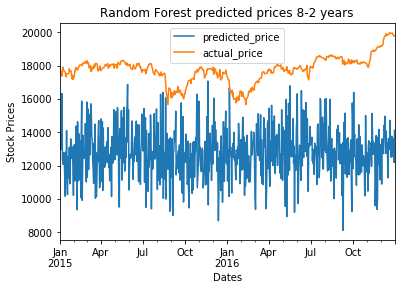

In [147]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices 8-2 years')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("graphs/random forest without smoothing.png")

colors = ['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499']

In [148]:
test.head()

,prices,compound,neg,neu,pos
2015-01-01,17828,-0.9299,0.138,0.74,0.122
2015-01-02,17832,-0.9775,0.149,0.759,0.093
2015-01-03,17722,-0.9737,0.131,0.787,0.083
2015-01-04,17612,-0.9971,0.22,0.716,0.064
2015-01-05,17501,-0.9905,0.156,0.767,0.077


# Increasing the prices by a constant value so that it represents closing price during the testing

In [157]:
from datetime import datetime, timedelta

temp_date = test_start_date
average_last_5_days_test = 0
total_days = 10
for i in range(total_days):
    average_last_5_days_test += test.loc[temp_date, 'prices']
    #print (average_last_5_days_test)
    
    # Converting string to date time
    temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
    
    # Reducing one day from date time
    difference = temp_date + timedelta(days=1)
    
    # Converting again date time to string
    temp_date = difference.strftime('%Y-%m-%d')
    
    #print temp_date
    
average_last_5_days_test = average_last_5_days_test / total_days
print (average_last_5_days_test, "avg 5")

temp_date = test_start_date
average_upcoming_5_days_predicted = 0
for i in range(total_days):
    average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
    
    # Converting string to date time
    temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
    
    # Adding one day from date time
    difference = temp_date + timedelta(days=1)
    
    # Converting again date time to string
    temp_date = difference.strftime('%Y-%m-%d')
    
    #print (temp_date)
average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
print (average_upcoming_5_days_predicted, "predicted")

difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
print (difference_test_predicted_prices)

17679.9 avg 5
13341.7566667 predicted
4338.14333333


In [158]:
predictions_df.head()

,prices
2015-01-01,13558.700
2015-01-02,13942.925
2015-01-03,12953.850
2015-01-04,13003.900
2015-01-05,14081.000


In [159]:
# Adding 6177 to all the advpredictions_df price values
predictions_df['prices'] = predictions_df['prices'] + difference_test_predicted_prices
predictions_df.head()

,prices
2015-01-01,17896.843333
2015-01-02,18281.068333
2015-01-03,17291.993333
2015-01-04,17342.043333
2015-01-05,18419.143333


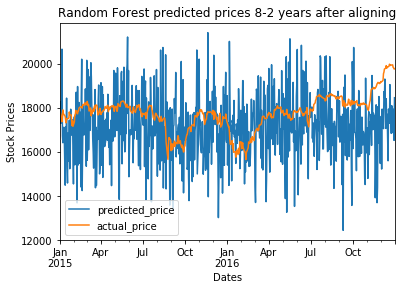

In [160]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices 8-2 years after aligning')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("graphs/random forest with aligning.png")

# Smoothing the time series data

# Applying EWMA pandas to smooth the stock prices

In [161]:
predictions_df.head()

,prices
2015-01-01,17896.843333
2015-01-02,18281.068333
2015-01-03,17291.993333
2015-01-04,17342.043333
2015-01-05,18419.143333


In [163]:
predictions_df['ewma'] = predictions_df["prices"].ewm(span=60,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()

In [164]:
predictions_df.head()

,prices,ewma
2015-01-01,17896.843333,17896.843333
2015-01-02,18281.068333,18092.157708
2015-01-03,17291.993333,17816.496970
2015-01-04,17342.043333,17691.888110
2015-01-05,18419.143333,17847.194730


In [169]:
predictions_df['actual_value'] = test['prices']
predictions_df['actual_value_ewma'] = predictions_df["actual_value"].ewm(span=60,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()

In [170]:
predictions_df.head()

,prices,ewma,actual_value,actual_value_ewma
2015-01-01,17896.843333,17896.843333,17828,17828.000000
2015-01-02,18281.068333,18092.157708,17832,17830.033333
2015-01-03,17291.993333,17816.496970,17722,17792.815295
2015-01-04,17342.043333,17691.888110,17612,17745.326592
2015-01-05,18419.143333,17847.194730,17501,17693.150223


In [172]:
# Changing column names
predictions_df.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
predictions_df.head()

,predicted_price,average_predicted_price,actual_price,average_actual_price
2015-01-01,17896.843333,17896.843333,17828,17828.000000
2015-01-02,18281.068333,18092.157708,17832,17830.033333
2015-01-03,17291.993333,17816.496970,17722,17792.815295
2015-01-04,17342.043333,17691.888110,17612,17745.326592
2015-01-05,18419.143333,17847.194730,17501,17693.150223


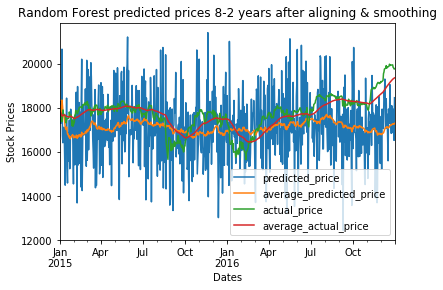

In [173]:
#Now plotting test predictions after smoothing
predictions_plot = predictions_df.plot(title='Random Forest predicted prices 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
fig.savefig("graphs/random forest after smoothing.png")


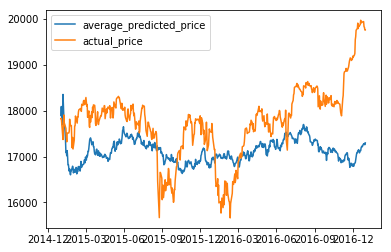

In [175]:
plt.plot(predictions_df.index, predictions_df['average_predicted_price'])
plt.plot(predictions_df.index, predictions_df['actual_price'])
plt.legend()

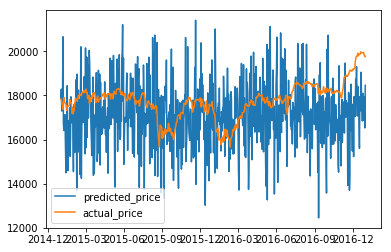

In [176]:
plt.plot(predictions_df.index, predictions_df['predicted_price'])
plt.plot(predictions_df.index, predictions_df['actual_price'])
plt.legend()

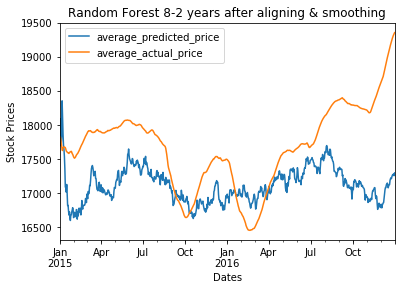

In [179]:
# # Plotting just predict and actual average curves
predictions_df_average = predictions_df[['average_predicted_price', 'average_actual_price']]
predictions_plot = predictions_df_average.plot(title='Random Forest 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
fig.savefig("graphs/random forest after smoothing 2.png")

# Increasing the prices by a constant value so that it represents closing price during the testing (Logistic Regression)

In [73]:
def offset_value(test_start_date, test, predictions_df):
    temp_date = test_start_date
    average_last_5_days_test = 0
    average_upcoming_5_days_predicted = 0
    total_days = 10
    for i in range(total_days):
        average_last_5_days_test += test.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_last_5_days_test = average_last_5_days_test / total_days

    temp_date = test_start_date
    for i in range(total_days):
        average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
    difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
    return difference_test_predicted_prices

# Logistic Regression

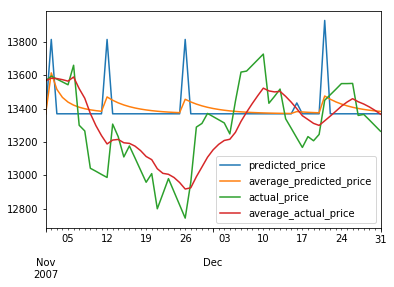

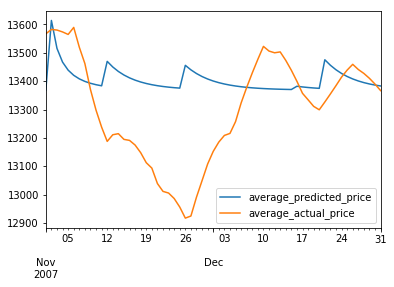

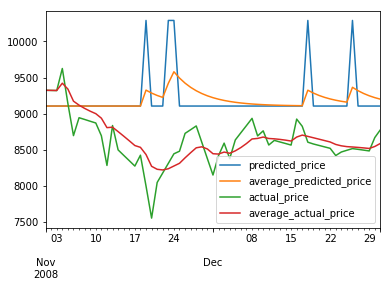

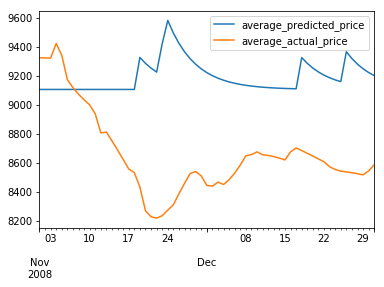

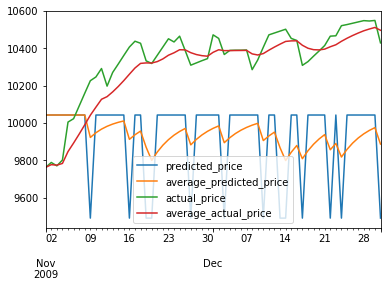

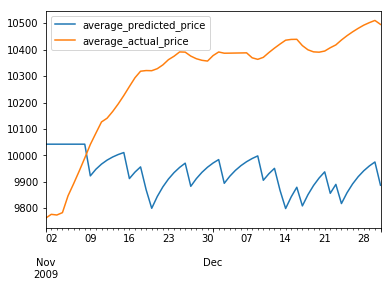

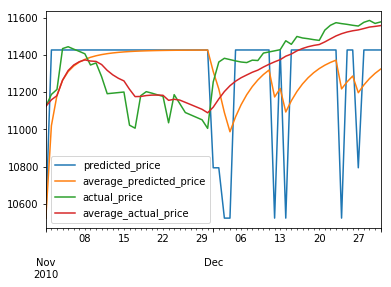

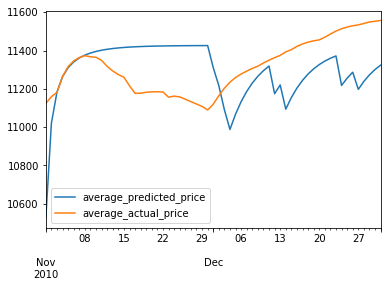

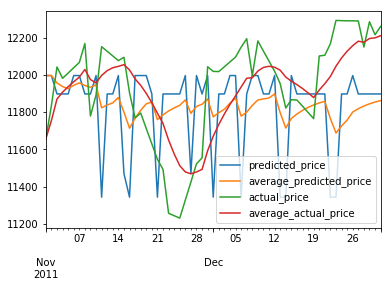

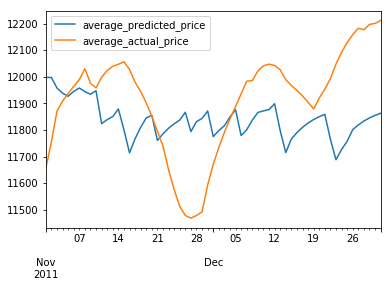

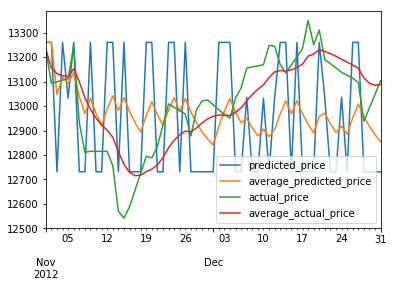

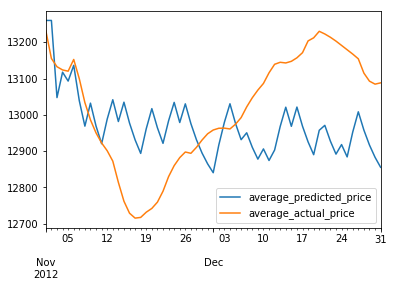

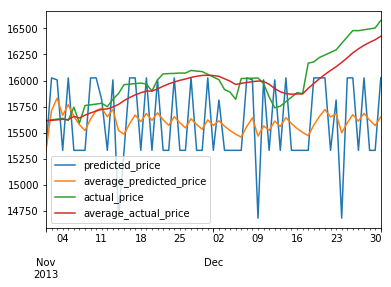

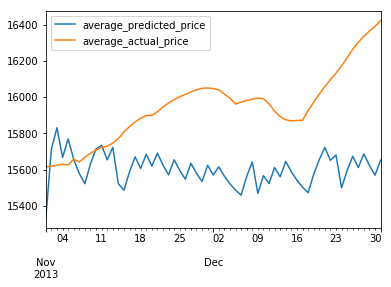

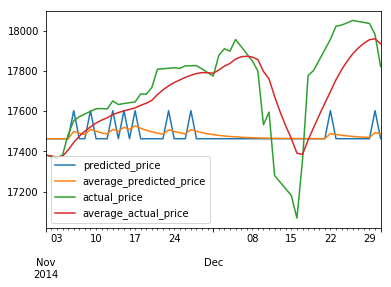

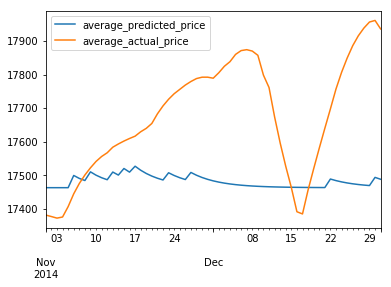

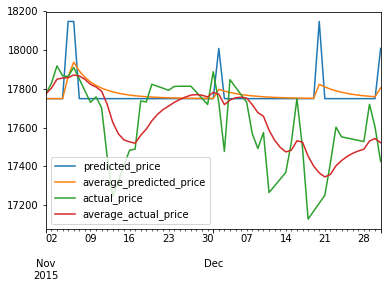

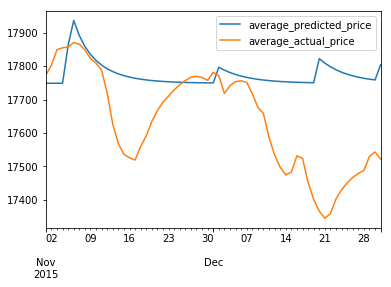

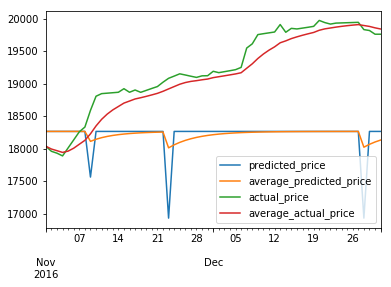

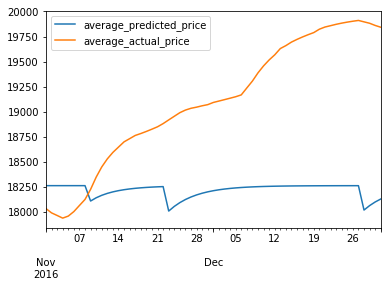

In [76]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta


years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    lr = LogisticRegression()
    lr.fit(numpy_df_train, train['prices'])
    

    prediction = lr.predict(numpy_df_test)
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = predictions_df_list['prices'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = predictions_df_list['actual_value'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
    

In [77]:
lr.classes_

array([15660, 15766, 15882, 15885, 15914, 15944, 15954, 15973, 15988,
       15995, 16002, 16009, 16014, 16016, 16024, 16027, 16029, 16069,
       16085, 16086, 16093, 16140, 16145, 16151, 16153, 16167, 16196,
       16204, 16336, 16346, 16363, 16379, 16381, 16391, 16398, 16413,
       16416, 16431, 16449, 16453, 16454, 16460, 16466, 16468, 16484,
       16514, 16516, 16544, 16557, 16598, 16620, 16639, 16697, 16865,
       16899, 16906, 16943, 16964, 16995, 17000, 17006, 17029, 17051,
       17073, 17140, 17148, 17158, 17213, 17217, 17218, 17223, 17227,
       17229, 17251, 17286, 17313, 17325, 17356, 17400, 17409, 17435,
       17481, 17492, 17495, 17498, 17500, 17502, 17515, 17520, 17525,
       17526, 17529, 17530, 17535, 17541, 17556, 17563, 17570, 17576,
       17582, 17593, 17602, 17603, 17609, 17616, 17623, 17633, 17640,
       17651, 17652, 17660, 17674, 17675, 17685, 17694, 17705, 17706,
       17710, 17711, 17716, 17717, 17718, 17720, 17721, 17729, 17732,
       17733, 17737,

In [78]:
lr.coef_[0]

array([ 0.79451559, -0.30429423, -1.86081504, -0.26253679])

# RandomForestRegressor

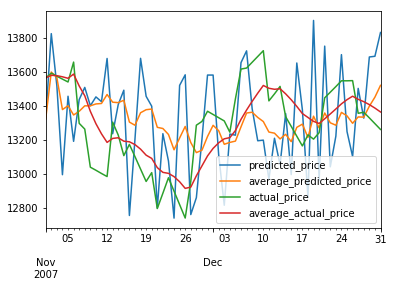

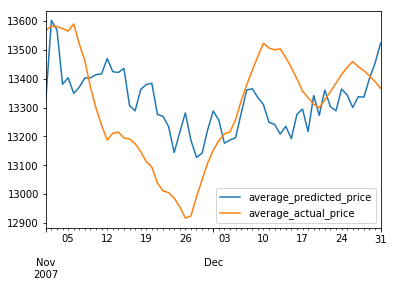

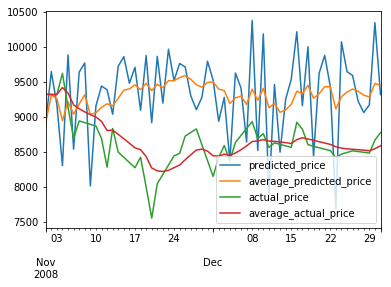

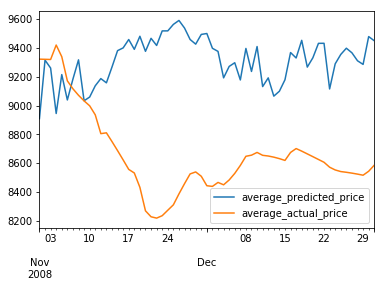

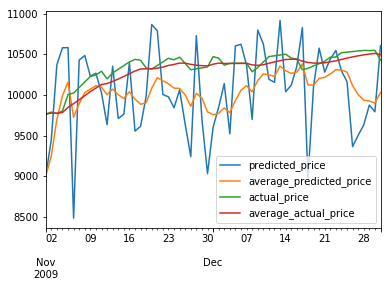

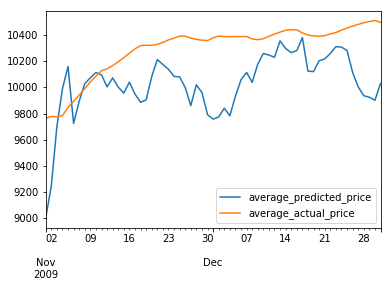

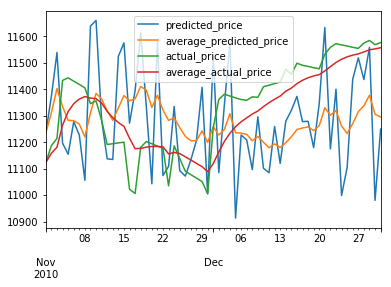

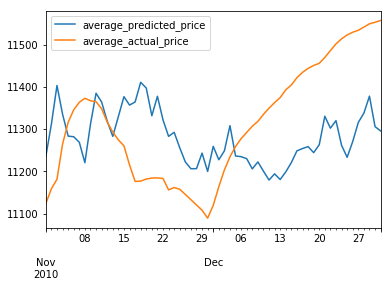

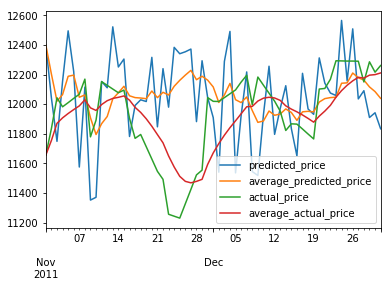

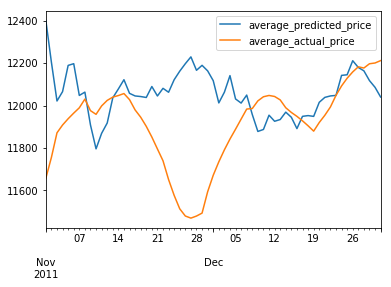

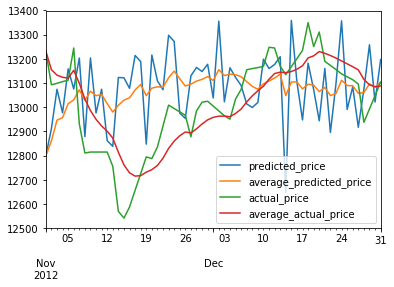

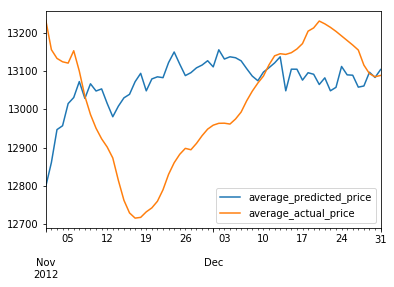

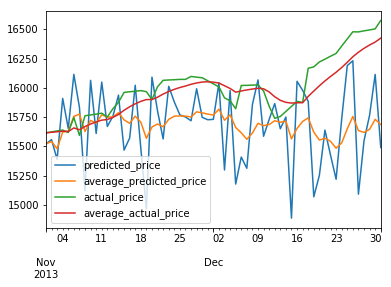

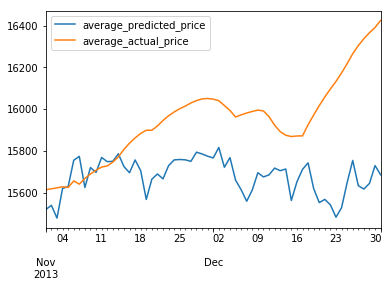

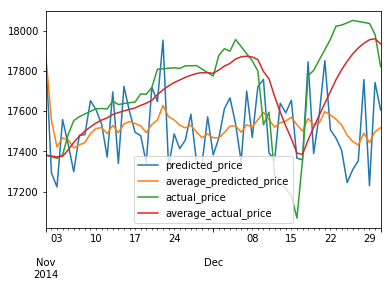

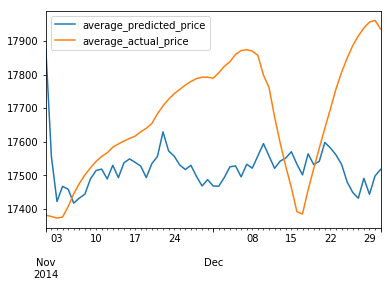

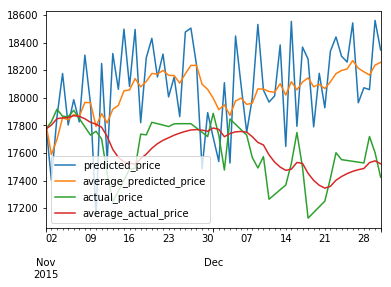

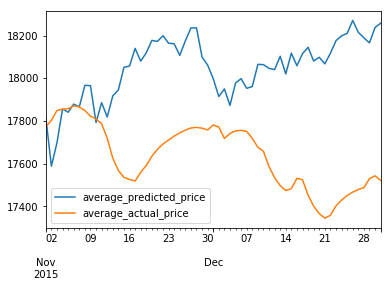

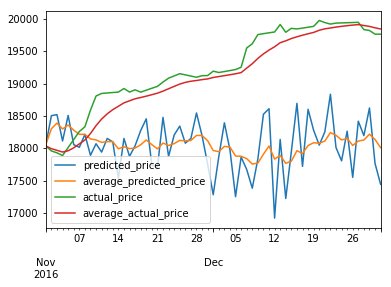

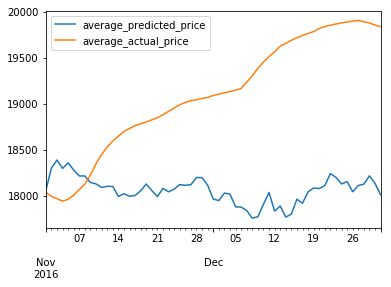

In [182]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta


years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    rf = RandomForestRegressor(random_state=42)
    rf.fit(numpy_df_train, train['prices'])
    #print rf
    
    prediction, bias, contributions = ti.predict(rf, numpy_df_test)
    prediction_list.append(prediction)
    #print (train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date)
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = predictions_df_list['prices'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = predictions_df_list['actual_value'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
    

In [82]:
# from IPython.display import Image  
# dot_data = tree.export_graphviz(rf, out_file=None, 
#                      feature_names=['comp', 'neg', 'neu', 'pos'],  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = pydotplus.graph_from_dot_data(dot_data)  
# Image(graph.create_png())

# MLP Classifier

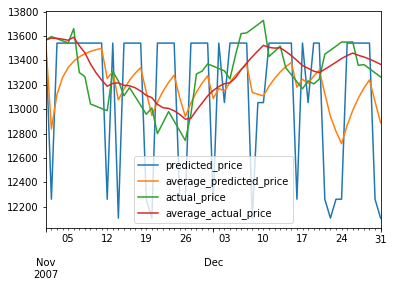

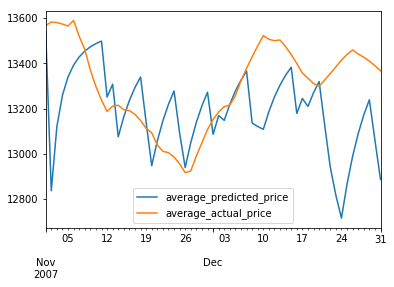

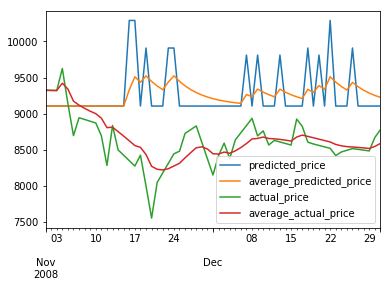

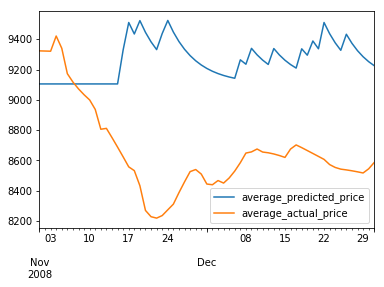

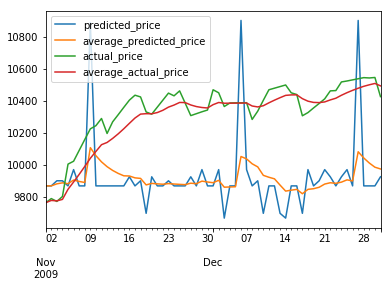

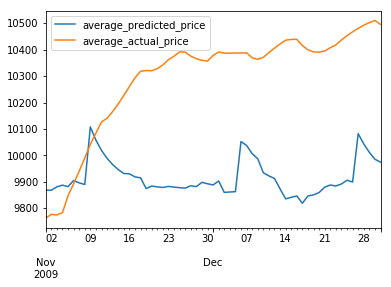

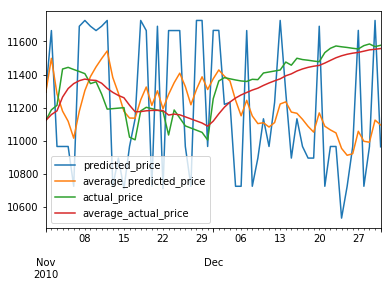

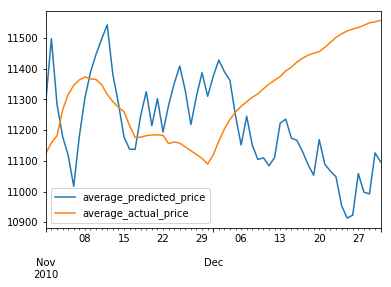

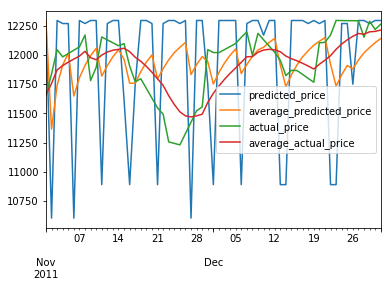

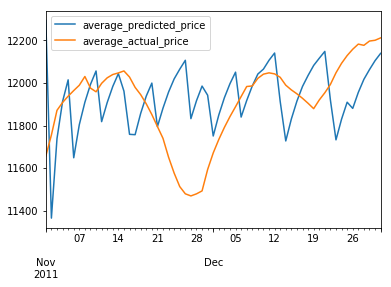

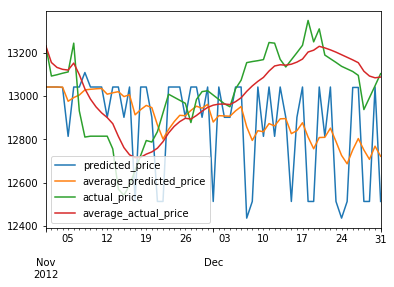

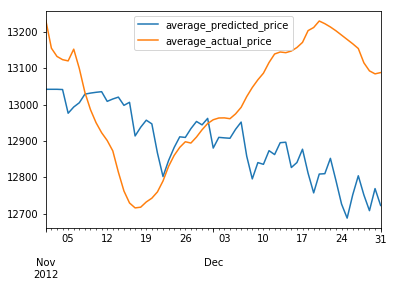

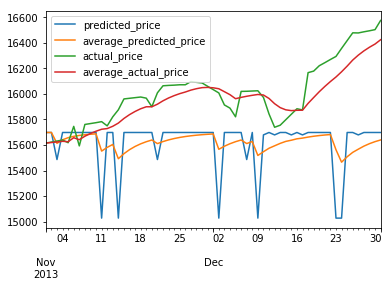

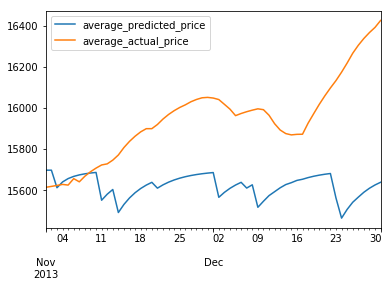

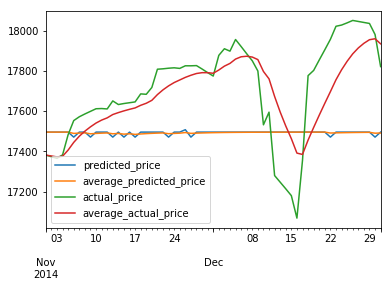

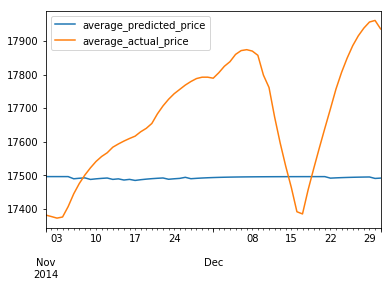

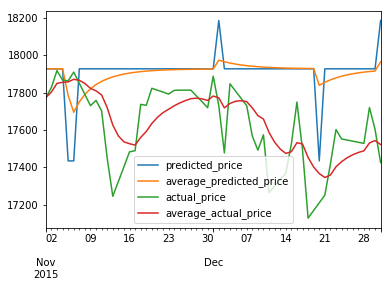

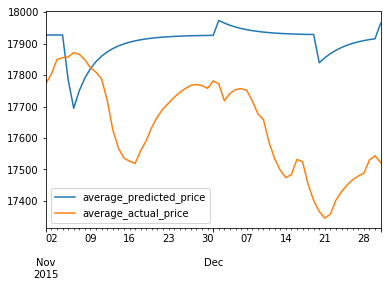

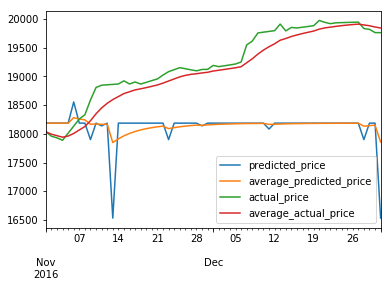

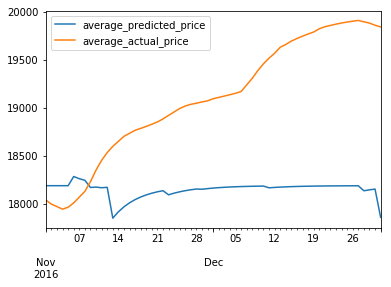

In [185]:
from sklearn.neural_network import MLPClassifier
from datetime import datetime, timedelta


years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.ix[train_start_date : train_end_date]
    test = df.ix[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    mlpc = MLPClassifier(hidden_layer_sizes=(500, 400, 300), activation='relu', 
                         solver='adam', alpha=0.005, learning_rate_init = 0.01, shuffle=True, learning_rate = "adaptive") # span = 20 # best 1
    mlpc.fit(numpy_df_train, train['prices'])   
    prediction = mlpc.predict(numpy_df_test)
    
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = predictions_df_list['prices'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = predictions_df_list['actual_value'].ewm(span=10,min_periods=0,freq="D",adjust=True,ignore_na=False).mean()
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
    
#     predictions_df_list.show()


In [89]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='tanh', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False)
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.010, learning_rate_init = 0.001, shuffle=False) # span = 20
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 50), activation='relu', 
                         solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False)

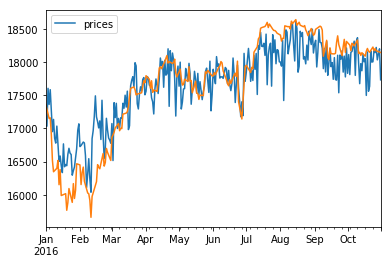

In [90]:
# checking the performance of training data itself
prediction, bias, contributions = ti.predict(rf, numpy_df_train)
idx = pd.date_range(train_start_date, train_end_date)
predictions_df1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
predictions_df1.plot() 
train['prices'].plot()

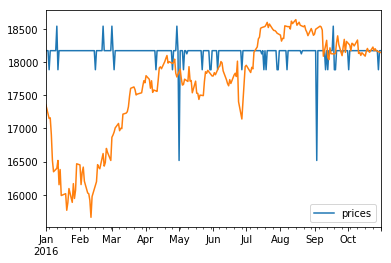

In [188]:
#Neural network training prediction

prediction= mlpc.predict(numpy_df_train)
idx = pd.date_range(train_start_date, train_end_date)
predictions_df1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
predictions_df1.plot() 
train['prices'].plot()